In [1]:
import os
os.chdir('../')

In [5]:
import cv2
from IPython.display import clear_output
import torch
from torch.functional import F
import numpy as np
from time import sleep
from einops.layers.torch import Rearrange
from torchvision.transforms import Compose

from src.opts.opts import parser
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset, prepare_clips_data
from src.dataset.utils import fgaid_to_fganame
from src.dataset.video_transforms import GroupMultiScaleCrop, Stack, ToTorchFormatTensor, GroupNormalize

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load config and adjust for local run
args = parser.parse_args([])
args.num_segments = 8
args.base_model = "InceptionV3" 
args.fusion_mode = "GSF" 
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist/HoloAssist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fga_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'base_model': 'InceptionV3',
 'fusion_mode': 'GSF',
 'num_segments': 8,
 'num_classes': 1887,
 'resume': None,
 'start_epoch': 0,
 'num_epochs': 10,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'batch_size': 16,
 'num_workers': 4,
 'prefetch_factor': 2,
 'debug': False,
 'fps': 10}

In [8]:
id_to_action_name_dict = fgaid_to_fganame(
    fga_map_file="/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt"
)

# Define model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=args.num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    verbose=False
).to(device)

crop_size = model.crop_size
input_mean = model.input_mean
input_std = model.input_std
div = model.div
model = torch.nn.DataParallel(model).to(device)

=> Using GSF fusion
No. of GSF modules = 11


# Load state

In [15]:
checkpoint = torch.load(
    f='checkpoints/holoassist_InceptionV3_GSF_action_10.pth', 
    map_location=torch.device(device)
)

# state_dict = {key[7:] if key.startswith('module.') else key: value for key, value in checkpoint['model_state_dict'].items()}
state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict=state_dict)
model.load_state_dict(state_dict=state_dict)
model.eval();

# Dataset

In [13]:
tr_video_name_arr, tr_start_arr, tr_end_arr, tr_label_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fga_map_file=args.fga_map_file,
    mode="train",
    task="action",
)

tr_transform = Compose([
    GroupMultiScaleCrop(crop_size, [1, .875]),
    Stack(roll=False),
    ToTorchFormatTensor(div=div),
    GroupNormalize(mean=input_mean, std=input_std), # this is for model and not for visualisation
])

tr_dataset = VideoDataset(
    holoassist_dir=args.holoassist_dir,
    video_name_arr=tr_video_name_arr,
    start_arr=tr_start_arr,
    end_arr=tr_end_arr,
    label_arr=tr_label_arr,
    num_segments=args.num_segments,
    transform=tr_transform,
    mode="train",
)


There are 9 videos in the split list file. 
There are 21 videos downloaded and stored on the disk 
There are 0 videos that present in the list but are missing on the disk.


In [17]:
len(tr_dataset)

627

In [63]:
# 177 -- 181
data, label = tr_dataset[123]
print(id_to_action_name_dict[label])

c_t, h, w = data.size()
preds = F.softmax(model(data.view(1, c_t, h, w)), dim=1)
_, largest_ids = torch.topk(preds, k=10, dim=1, largest=True, sorted=True)
print([id_to_action_name_dict[i.item()] for i in largest_ids[0]])

insert-screw
['insert-screw', 'grab-screw', 'insert-bolt', 'align-screw', 'lift-screw', 'withdraw-screw', 'insert-sd_card', 'place-screw', 'lift-sd_card', 'insert-screwdriver']


In [64]:
preds.shape

torch.Size([1, 1887])

In [65]:
rearranged_data = Rearrange("(t c) h w -> t h w c", t=args.num_segments, c=3, h=299, w=299)(data)
print(rearranged_data.shape)

# choose first frame
img = rearranged_data[0]
img = img * np.array(input_std) + np.array(input_mean)

# plt.imshow(img);
# plt.axis('off');

torch.Size([8, 299, 299, 3])


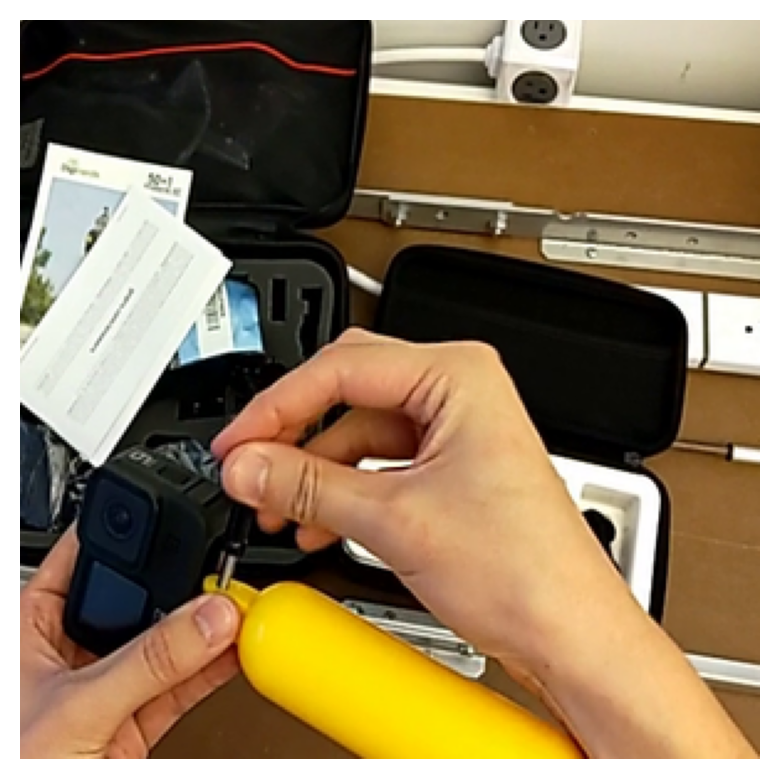

In [66]:
plt.figure()
for i in range(len(rearranged_data)):
    frame = rearranged_data[i]
    frame = frame * np.array(input_std) + np.array(input_mean)
    plt.imshow(frame)
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

# CAM

In [67]:
# !pip install grad-cam

In [68]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [69]:
target_layers = [model.module.base_model.mixed_10_tower_2_conv]
# target_layers = [model.base_model.mixed_10_tower_2_conv_Conv2D]

# cam = GradCAM(model=model, target_layers=target_layers)
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(label+1)]
grayscale_cams = cam(input_tensor=data.view(1, c_t, h, w), targets=targets)
grayscale_cams.shape

(8, 299, 299)

In [70]:
images = []
cam_images = []
for segment in range(args.num_segments):

    img = rearranged_data[segment]
    img = img * np.array(input_std) + np.array(input_mean) # inverse norm
    # img = img[:, :, [2, 1, 0]] # bgr -> rgb
    # img = img / 255 # [0...255] -> [0...1]

    cam_image = show_cam_on_image(
        img=np.array(img), 
        mask=grayscale_cams[segment], 
        use_rgb=True, 
        image_weight=0.5
    )
    images.append(img)
    cam_images.append(cam_image)

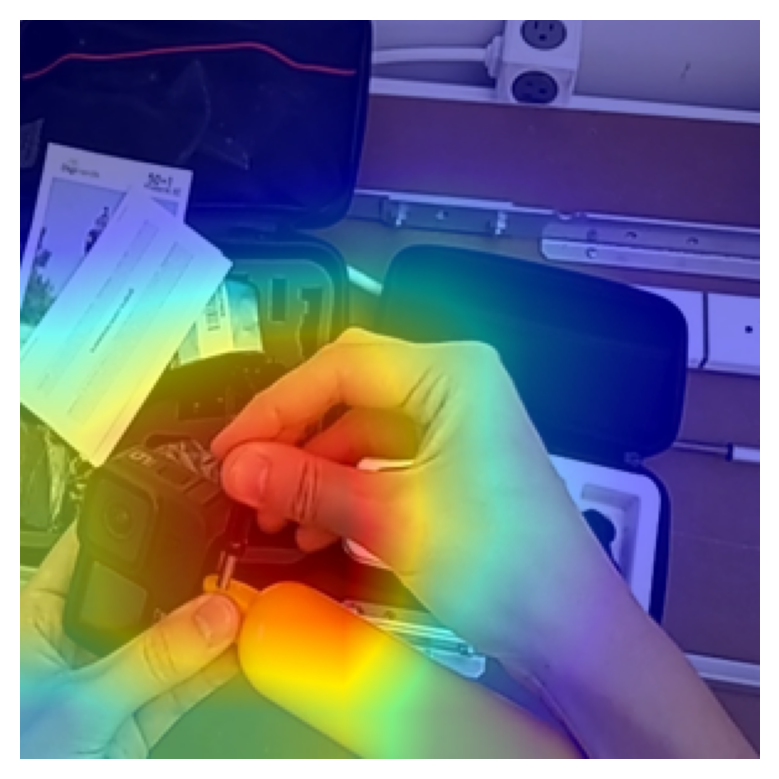

In [71]:
plt.figure()
for i in range(len(cam_images)):
    plt.imshow(cam_images[i])
    plt.axis('off')  
    plt.show()
    sleep(0.01)
    clear_output(wait=True)